In [1]:
import numpy as np
import music21
from music21 import converter
from music21 import stream
from music21.note import Note
from copy import deepcopy

## Helpers

In [2]:
def repeat_stream(s, num_repeats):
    s2 = deepcopy(s)
    for _ in range(num_repeats - 1):
        for el in s:
            s2.append(deepcopy(el))
    return s2

In [3]:
def append_mirror(mylist):
    return mylist + mylist[::-1]

In [4]:
def mirror_note_diatonic(note, scale, center_degree=1):
    center_pitch = scale.pitchFromDegree(center_degree)
    steps = note.pitch.diatonicNoteNum - center_pitch.diatonicNoteNum
    
    degree = (-1 * steps) % 7 + 1
    pitch = scale.pitchFromDegree(degree)
    
    relative_octave = -1 * (steps // 7)
    if steps % 7 != 0: relative_octave -= 1
    pitch.octave += relative_octave

    return Note(deepcopy(pitch))

def mirror_diatonic(stream, scale, center_degree=1):
    s = music21.stream.Stream()
    for note in stream.notes:
        n = mirror_note_diatonic(note, scale, center_degree=center_degree)
        s.append(n)
    return s

## Text: Credo

In [5]:
def syllabify(text):
    syllables = []
    for phrase in text.split('\n'):
        for word in phrase.split(' '):
            sylls = word.split('-')
            for i, syll in enumerate(sylls):
                if i < len(sylls) - 1:
                    syll += '-'
                syllables.append(syll)
    return syllables

In [6]:
CREDO = """
Cre-do in u-num de-um,
Pa-trem o-mni-po-ten-tem,
fa-cto-rem coe-li et ter-rae,
vi-si-bi-li-um o-mni-um,
et in-vi-si-bi-li-um,
et in u-num Do-mi-num Je-sum Chri-stum,
Fi-li-um De-i u-ni-ge-ni-tum,
et ex Pa-tre na-tum an-te o-mni-a sae-cu-la.
De-um de De-o, lu-men de lu-mi-ne,
De-um ve-rum de De-o ve-ro,
ge-ni-tum,
non fa-ctum,
con-sub-stan-ti-a-lem Pa-tri:
per quem o-mni-a fac-ta sunt.
Qui prop-ter nos ho-mi-nes,
et pro-pter no-stram sa-lu-tem de-scen-dit de coe-lis.
Et in-car-na-tus est de Spi-ri-tu San-cto ex Ma-ri-a Vir-gi-ne:
Et ho-mo fa-ctus est.
Cru-ci-fi-xus e-ti-am pro no-bis sub Pon-ti-o Pi-la-to pas-sus et se-pul-tus est.
Et re-sur-re-xit ter-ti-a di-e,
se-cun-dum scri-ptu-ras.
Et a-scen-dit in coe-lum,
se-det ad dex-te-ram Pa-tris.
Et i-te-rum ven-tu-rus est cum glo-ri-a,
ju-di-ca-re vi-vos et mor-tu-os,
cu-jus re-gni non e-rit fi-nis.
Et in Spi-ri-tum San-ctum,
Do-mi-num,
et vi-vi-fi-can-tem:
qui ex Pa-tre Fi-li-o-que pro-ce-dit.
Qui cum Pa-tre et Fi-li-o si-mul ad-o-ra-tur,
et con-glo-ri-fi-ca-tur,
qui lo-cu-tus est per Pro-phe-tas.
Et u-nam san-ctam ca-tho-li-cam et a-po-sto-li-cam Ec-cle-si-am.
Con-fi-te-or u-num ba-pti-sma in re-mis-si-o-nem pec-ca-to-rum.
Et ex-spe-cto re-sur-re-cti-o-nem mor-tu-o-rum,
et vi-tam ven-tu-ri sae-cu-li.
A-men""".strip()

In [7]:
SYLLABLES = syllabify(CREDO)
SYLLABLES[:5]

['Cre-', 'do', 'in', 'u-', 'num']

## Basic structure

The piece is organized in 16 sections of three measures, each containing 7, 9 and 7 syllables respectively. 
The number of quarter notes per measure varies, but the number of syllables follows the same pattern throughout.
The divisi change from measure to measure and mirror the divisi in the previous section.
Concretely, the first section (mm. 1–3) has divisi SA, SATB and TB, and so the second section (mm. 4–6) has divisi TB, SATB and SA.

Note that the final two bars deviate from the otherwise completely regular pattern: the final two bars contain 4 and 1 syllables respectively, both in SATB divisi.

In [8]:
SYLLABLES_PER_MEASURE = [7, 9, 7] * 16
DIVISI = ['SA', 'SATB', 'TB', 'TB', 'SATB', 'SA'] * 8

In [9]:
# Final bars
SYLLABLES_PER_MEASURE[-1] = 4
SYLLABLES_PER_MEASURE.append(1)
DIVISI.append('SATB')

assert sum(SYLLABLES_PER_MEASURE) == len(SYLLABLES)

In [10]:
print('Sec Bar Sylls Divisi  Text')
print('—'*70)
pos = np.cumsum(SYLLABLES_PER_MEASURE).tolist()
for m, (length, divisi, start, end) in enumerate(
        zip(SYLLABLES_PER_MEASURE, DIVISI, [0] + pos, pos)):
    measure = " ".join(SYLLABLES[start:end]).replace('- ', '-')
    rehearsal = m // 3 + 1 if m % 3 == 0 else ''
    print(f'{rehearsal: <3} {m+1: <2}  {length}     {divisi: <4}    {measure}')

Sec Bar Sylls Divisi  Text
——————————————————————————————————————————————————————————————————————
1   1   7     SA      Cre-do in u-num de-um,
    2   9     SATB    Pa-trem o-mni-po-ten-tem, fa-cto-
    3   7     TB      rem coe-li et ter-rae, vi-
2   4   7     TB      si-bi-li-um o-mni-um,
    5   9     SATB    et in-vi-si-bi-li-um, et in
    6   7     SA      u-num Do-mi-num Je-sum
3   7   7     SA      Chri-stum, Fi-li-um De-i
    8   9     SATB    u-ni-ge-ni-tum, et ex Pa-tre
    9   7     TB      na-tum an-te o-mni-a
4   10  7     TB      sae-cu-la. De-um de De-
    11  9     SATB    o, lu-men de lu-mi-ne, De-um
    12  7     SA      ve-rum de De-o ve-ro,
5   13  7     SA      ge-ni-tum, non fa-ctum, con-
    14  9     SATB    sub-stan-ti-a-lem Pa-tri: per quem
    15  7     TB      o-mni-a fac-ta sunt. Qui
6   16  7     TB      prop-ter nos ho-mi-nes, et
    17  9     SATB    pro-pter no-stram sa-lu-tem de-scen-
    18  7     SA      dit de coe-lis. Et in-car-
7   19  7     SA   

In [11]:
def init_score(measure_syllable_counts, measure_divisi):
    # Set up parts
    score = stream.Score()
    score.soprano = stream.Part(id='soprano')
    score.alto = stream.Part(id='alto')
    score.tenor = stream.Part(id='tenor')
    score.bass = stream.Part(id='bass')
    parts = [score.soprano, score.alto, score.tenor, score.bass]
    score.append(parts)
    
    # Metadata
    score.editorial['measures'] = len(measure_syllable_counts)
    score.editorial['measure_syllable_counts'] = measure_syllable_counts
    score.editorial['measure_divisi'] = measure_divisi

    # Insert measures
    for syllable_count, divisi in zip(measure_syllable_counts, measure_divisi):
        for part in parts:
            measure = stream.Measure()
            measure.editorial['syllable_count'] = syllable_count
            measure.editorial['divisi'] = divisi
            measure.editorial['active'] = part.id[0].upper() in divisi
            part.append(measure)

    # Set clefs
    bass_clef = music21.clef.BassClef()
    score.bass.measure(1).append(bass_clef)
    tenor_clef = music21.clef.Treble8vbClef()
    score.tenor.measure(1).append(tenor_clef)
    
    # Key signature
    key = music21.key.KeySignature(1)
    for part in parts:
        part.measure(1).append(key)
        
    return score

score = init_score(SYLLABLES_PER_MEASURE, DIVISI)

## Basic melodic material

### Alto


The basic material for both the alto and the bass is an E aeolean scale. The alto for example starts on an E3, descends down to an E4 and goes up to G4, to descend again. Now it however skips the root E4. So essentially it repeats the following 15-note pattern 16 times, but starts and ends that whole sequence with an E. One could say that starting from the resting position, it avoids the closing tonic, until the very last note.

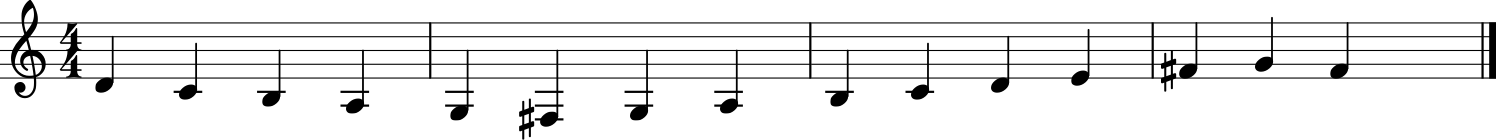

In [12]:
alto_pattern = converter.parse("tinynotation: d c B A G F# G A B c d e f# g f#").flat.notes
alto_pattern.show()

In [13]:
def get_alto_notes(pattern):
    notes = repeat_stream(pattern, 16)
    notes.insertAndShift(0, music21.note.Note('E4')) 
    notes.append(music21.note.Note('E4'))
    return notes

alto_notes = get_alto_notes(alto_pattern)

### Bass

The bass goes through a similar 15-note pattern 16 times, starting and ending on an E. 
The pattern however starts ascending, rather than descending. 
So the bass pattern is really just the mirror image of the alto, mirrored in the tonic E4, and transposed an octave down:

In [14]:
def get_bass_pattern(pattern):
    scale = music21.scale.MinorScale(tonic='E4')
    bass_pattern = mirror_diatonic(pattern, scale=scale, center_degree=1)
    bass_pattern = bass_pattern.transpose(-12)
    return bass_pattern

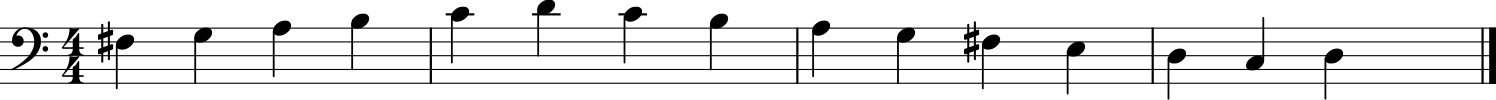

In [15]:
bass_pattern = get_bass_pattern(alto_pattern)
bass_pattern.show()

In [16]:
def get_bass_notes(pattern):
    notes = repeat_stream(pattern, 16)
    notes.insertAndShift(0, music21.note.Note('E3'))
    notes.append(music21.note.Note('E4'))
    return notes

bass_notes = get_bass_notes(bass_pattern)

### Tenor

In [17]:
tenor_pitches = ['E3', 'G3', 'B3', 'E4', 'G4']
tenor_pitches = [Note(n) for n in tenor_pitches]

def tintanibulli_above(note, steps = 1):
    i = 0
    for p in tenor_pitches:
        if note < p:
            i += 1
            if i == steps:
                return deepcopy(p)
    return None

def tintanibulli_below(note, steps = 1):
    i = 0
    for p in tenor_pitches[::-1]:
        if p < note:
            i += 1
            if i == steps:
                return deepcopy(p)
    return None

In [18]:
def get_tenor_notes(bass_notes):
    notes = stream.Stream()
    prev = Note('E3')
    for n1, n2 in zip(bass_notes, bass_notes[1:]):
        if n1 < n2:
            # Ascending
            next_note = tintanibulli_above(prev)
            if next_note is None or next_note == n2:
                next_note = tintanibulli_below(prev)

        elif n1 > n2:
            next_note = tintanibulli_below(prev)
            if next_note is None or next_note == n2:
                next_note = tintanibulli_above(prev)

        notes.append(next_note)
        prev = next_note

    notes.insertAndShift(0, Note('B3'))
    return notes

tenor_notes = get_tenor_notes(bass_notes)

## Melismas

In [19]:
def get_melismas(pattern, corrections, skip_final, num_repetitions=17):
    melismas = [deepcopy(pattern) for _ in range(num_repetitions)]
    for (rep, idx), correction in corrections.items():
        melismas[rep - 1][idx - 1] = correction   
    
    melismas = [n for pat in melismas for n in pat]
    return [None] + melismas[:-skip_final] + [None]

### Soprano

In [20]:
# To do
soprano_melismas = [None for _ in alto_notes]

### Alto

In [21]:
alto_melismas_raw = [
    None,
    # 1
    None, 'G3', None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    # 2
    'B3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    # 3
    None, 'G3', None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    # 4
    'E4', None, 'G3', None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, 'B3',
    # 5
    None, 'E4', None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None,
    # 6
    'G3', None, None, None, None, None, 'E3', None, None, 'B3', None, None, None, None, None,
    # 7
    'G3', None, None, None, None, None, None, None, None, 'B3', None, None, None, None, None, 
    # 8
    'G3', None, None, None, 'B3', None, None, None, None, 'B3', None, None, None, None, None, 
    # 9
    'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None, 
    # 10
    'G3', None, None, None, 'B3', None, 'E3', None, None, None, None, None, None, None, None, 
    # 11
    'G3', None, None, None, 'B3', None, 'E3', None, 'G3', None, None, None, None, None, None, 
    # 12
    'G3', None, None, None, 'B3', None, 'E3', None, None, None, None, None, None, None, None, 
    # 13
    'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None, 
    # 14
    'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None, 
    # 15
    'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None, 
    # 16
    'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None, 
    # 17
    None, 'G3', None, None, 'B3', None, 'E3', None, None, 'B3', None, 
    # End
    None, None   
]

In [22]:
alto_corrections = {
    (1, 1): None, (1, 2): 'G3',
    (2, 1): 'B3', 
    (3, 1): None, (3, 2): 'G3', 
    (4, 1): 'E4', (4, 3): 'G3', (4, 15): 'B3',
    (5, 1): None, (5, 2): 'E4', 
    (6, 5): None,
    (7, 5): None, (7, 7): None,
    (8, 7): None,
    (10, 10): None,
    (11, 9): 'G3', (11,10): None,
    (12, 10): None,
    (17, 1): None, (17, 2): 'G3'
}

In [23]:
alto_melisma_pattern = [
    'G3', None, None, None, 'B3', None, 'E3', None, None, 'B3', None, None, None, None, None]

In [24]:
alto_melismas = get_melismas(alto_melisma_pattern, alto_corrections, 3)

# Test for equality
for i, n in enumerate(alto_melismas_raw): 
    assert n == alto_melismas[i]

alto_melismas = [None if n is None else Note(n) for n in alto_melismas]

### Tenor

In [25]:
tenor_melismas = [
    None,
    None, 'G3', None, None, None, None, None, None, None, 'E4', None, None, 'B3', None, 'E3',
    None, None, None, None, None, None, None, None, None, None, 'E4', 'B3', None, None, None,
    None, None, None, None, None, None, None, None, None, 'E4', None, None, 'B3', None, 'E4', 
    None, 
    # To do 
]
tenor_melismas = [None if n is None else Note(n) for n in tenor_melismas]
tenor_melismas += [None] * (len(alto_melismas) - len(tenor_melismas))

### Bass

In [26]:
bass_melismas = [
    None,
    # 1
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 2
    None, None, None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 3
    None, None, None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 4
    None, None, None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 5
    None, 'E3', None, None, None, None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 6
    None, 'E3', None, None, None, None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 7
    None, 'E3', None, None, None, None, None, None, None, 'E3', None, None, None, None, 'B2',
    # 8
    None, 'E3', None, None, 'B3', None, None, None, None, 'E3', None, None, None, None, 'B2',
    # 9
    None, 'E3', None, None, 'B3', None, None, None, None, 'E3', None, None, None, None, 'B2',
    # 10
    None, 'E3', None, None, 'B3', None, 'G3', None, None, None, None, None, None, None, 'B2',
    # 11
    None, 'E3', None, None, 'B3', None, 'G3', None, None, None, None, None, None, None, 'B2',
    # 12
    None, 'E3', None, None, 'B3', None, 'G3', None, None, None, None, None, None, None, 'B2', 
    # 13
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 14
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, 'B2',
    # 15
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, None, 
    # 16
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, None, 
    # 17
    None, 'E3', None, None, 'B3', None, 'G3', None, None, 'E3', None, None, None, None, None, 
    # End
    None, None
]
bass_melismas = [None if n is None else Note(n) for n in bass_melismas]

**TO DO** Seems as if the bass melismas follow a simple pattern from which Part only deviates around section openings/endings. Maybe something along the lines 'no melismas at the initial 2 or final 2 notes?

## Insert syllables

In [27]:
class Syllable(music21.stream.Stream):
    def __init__(self, *args, index=None, text=''):
        self.text_ = text
        self.index_ = index
        super().__init__(*args)
    
    def setDuration(self, quarterLength):
        note_duration = quarterLength / len(self.notes)
        for note in self.notes:
            note.quarterLength = note_duration
            
    def setLyrics(self, text):
        self.notes[0].lyric = text

In [28]:
def get_syllables(notes, melismas):
    syllables = []
    for note, melisma in zip(notes, melismas):
        syll = Syllable(deepcopy(note))
        if melisma is not None: 
            syll.append(deepcopy(melisma))
        syllables.append(syll)
    return syllables

# To do: soprano
alto_syllables = get_syllables(alto_notes, alto_melismas)
tenor_syllables = get_syllables(tenor_notes, tenor_melismas)
bass_syllables = get_syllables(bass_notes, bass_melismas)

In [29]:
def insert_syllables(syllables, measure, text_syllables):
    for syllable, text in zip(syllables, text_syllables):
        syllable.setLyrics(text)
        for note in syllable.notes:
            measure.append(note)
        if len(syllable.notes) > 1:
            slur = music21.spanner.Slur([n for n in syllable.notes])
            measure.insert(0, slur)
            
score = init_score(SYLLABLES_PER_MEASURE, DIVISI)
alto_iter = iter(alto_syllables)
bass_iter = iter(bass_syllables)
tenor_iter = iter(tenor_syllables)
text_iter = iter(SYLLABLES)

for m in range(1, score.editorial['measures'] - 3):
    syll_count = score.bass.measure(m).editorial['syllable_count']
    divisi = score.bass.measure(m).editorial['divisi']
    text_sylls = [next(text_iter) for _ in range(syll_count)]
    
    # Collect alto syllables
    alto_sylls = []
    if 'A' in divisi:
        alto_sylls = [next(alto_iter) for _ in range(syll_count)]
    
    # Collect bass syllables
    bass_sylls = []
    if 'B' in divisi:
        bass_sylls = [next(bass_iter) for _ in range(syll_count)]
    
    # Align bass and alto syllable duration
    if divisi == 'SATB':
        for alto_syll, bass_syll in zip(alto_sylls, bass_sylls):
            duration = max(alto_syll.quarterLength, bass_syll.quarterLength)
            alto_syll.setDuration(duration)
            bass_syll.setDuration(duration)
    
    # Tenor syllables
    tenor_sylls = []
    if 'T' in divisi:
        tenor_sylls = [next(tenor_iter) for _ in range(syll_count)]
        for i, tenor_syll in enumerate(tenor_sylls):
            tenor_syll.setDuration(bass_sylls[i].quarterLength)

    insert_syllables(alto_sylls, score.alto.measure(m), text_sylls)
    insert_syllables(bass_sylls, score.bass.measure(m), text_sylls)
    insert_syllables(tenor_sylls, score.tenor.measure(m), text_sylls)

## Finalize score

In [30]:
def set_time_signatures(score):
    for m in range(score.editorial['measures']):
        bar_duration = int(score.measure(m+1).quarterLength)
        if bar_duration == 0: continue
        t = music21.meter.TimeSignature(f'{bar_duration}/4')
        t.style.hideObjectOnPrint = True
        for part in score.parts:
            part.measure(m+1).timeSignature = t

In [31]:
set_time_signatures(score)

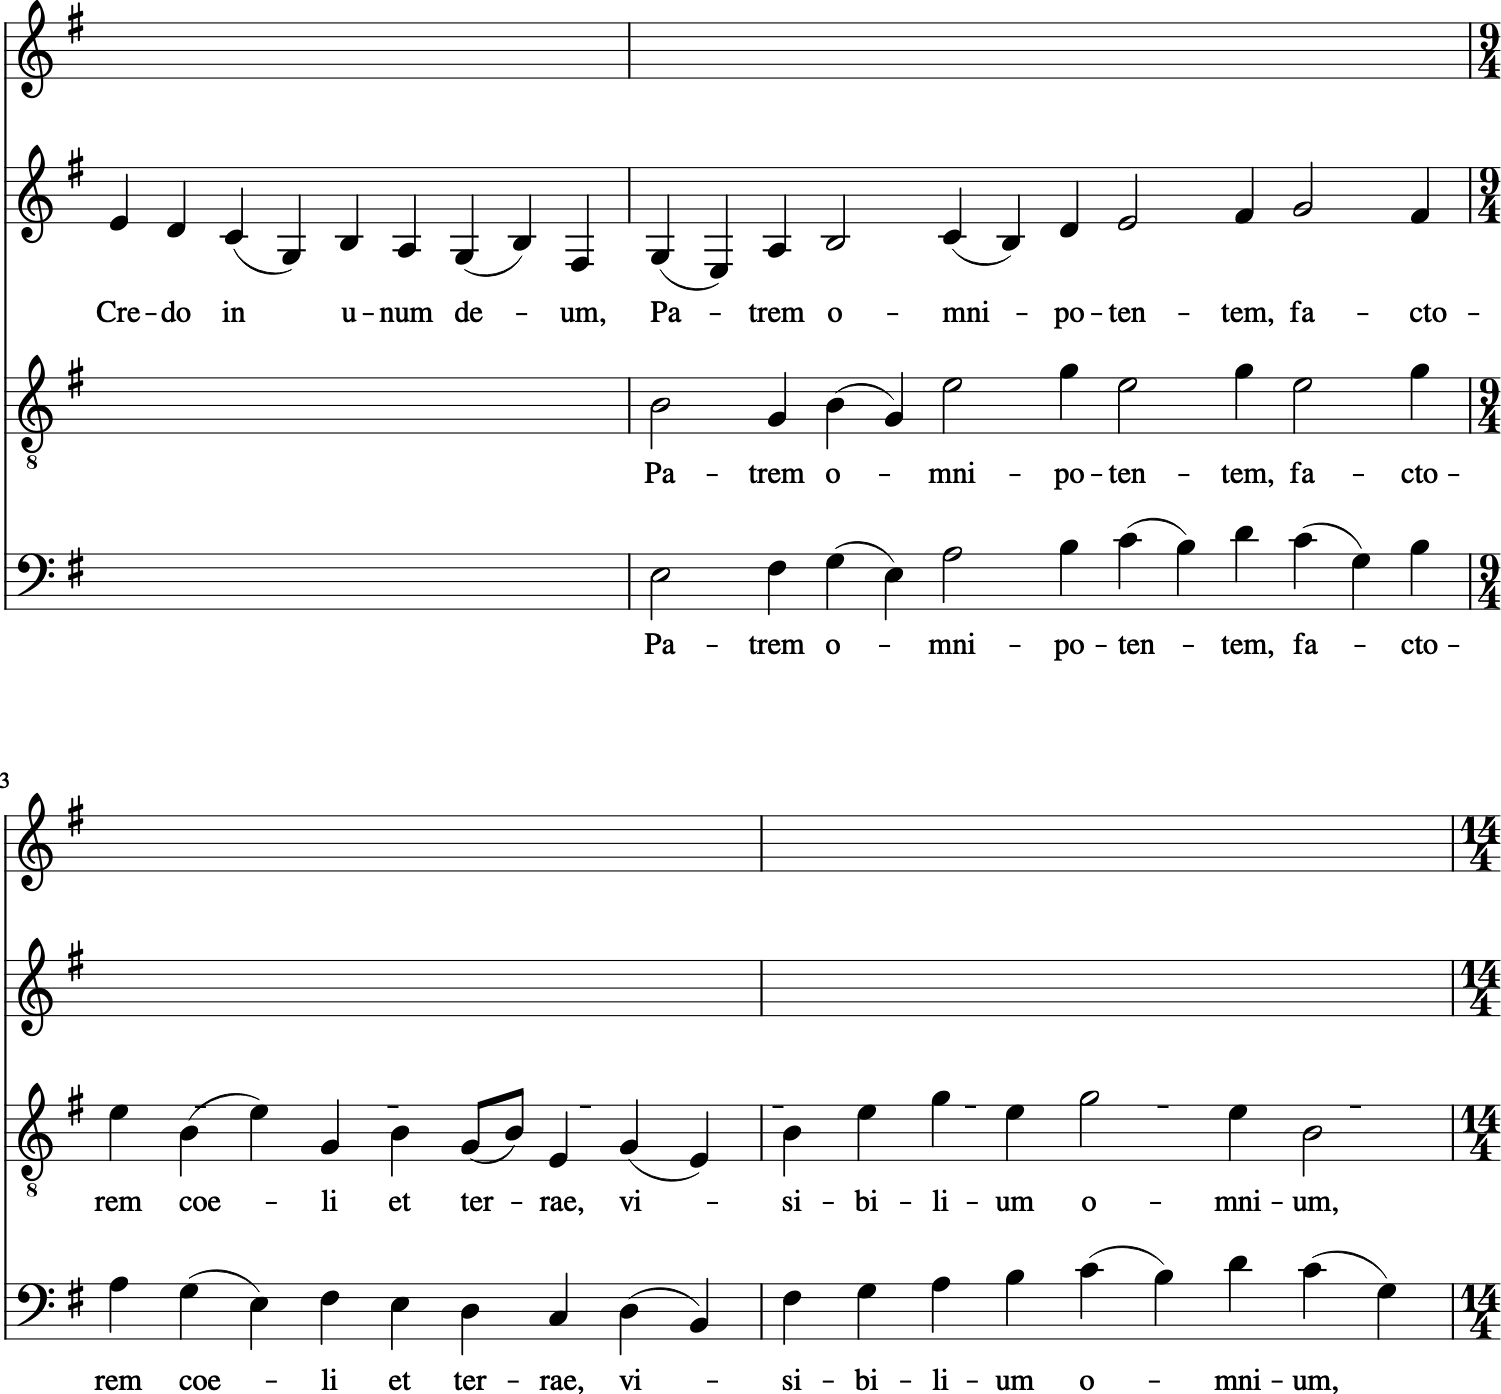

In [32]:
score.measures(1, 6).show()

## To do

* Add soprano tintanibulli voice
* Add tenor melismas
* Add soprano melismas
* Simplify melismas to pattern
* Fix notes at entrances